In [1]:
import pandas as pd

In [125]:
train_df = pd.read_csv('../dataset/train.csv')

In [63]:
train_df.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia


In [5]:
# train과 dev 8:2로 나누기

from sklearn.model_selection import train_test_split

train_df, dev_df = train_test_split(train_df, test_size=0.2, random_state=1234)

In [6]:
train_df.shape, dev_df.shape

((25976, 6), (6494, 6))

In [9]:
# 저장하기

train_df.to_csv('./dataset/base_train.csv', index=False)
dev_df.to_csv('./dataset/base_dev.csv', index=False)

## Source가 label에 끼치는 영향 분석

In [64]:
train_df['source'].value_counts()

source
wikipedia          21620
wikitree           10672
policy_briefing      178
Name: count, dtype: int64

In [90]:
# sourece별 label 분포 확인

train_df.groupby(['source', 'label']).size().reset_index(name='count') 

,source,label,count
0,policy_briefing,no_relation,30
1,policy_briefing,org:alternate_names,6
2,policy_briefing,org:member_of,8
3,policy_briefing,org:members,1
4,policy_briefing,org:number_of_employees/members,3
...,...,...,...
64,wikitree,per:religion,2
65,wikitree,per:schools_attended,10
66,wikitree,per:siblings,14
67,wikitree,per:spouse,359


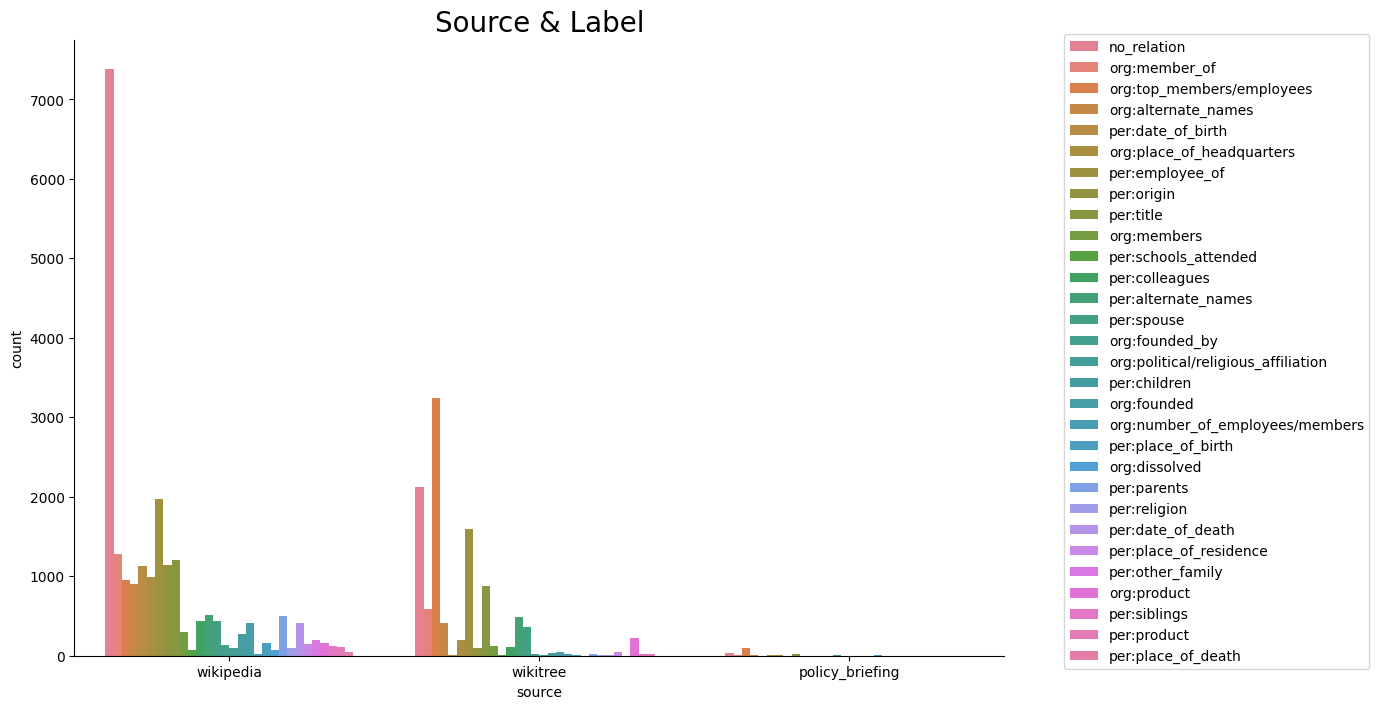

In [86]:
# source별 label 분포 시각화

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
ax = sns.countplot(data=train_df, x='source', hue='label')
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.02))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Source & Label', fontsize=20)

plt.show()

## 라벨 별 문장 길이 분석

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
from transformers import AutoTokenizer

In [104]:
train_df = pd.read_csv('../dataset/train.csv')

In [4]:
# 라벨 별 문장 길이 분석

MODEL = 'klue/roberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL)

train_df['length'] = train_df['sentence'].apply(lambda x: len(x))
train_df['token_length'] = train_df['sentence'].apply(lambda x: len(tokenizer.tokenize(x))) # without special tokens

In [5]:
train_df[['length','token_length']].describe()


,length,token_length
count,32470.000000,32470.000000
mean,97.083954,50.958608
std,47.939902,24.921942
min,14.000000,7.000000
25%,64.000000,34.000000
50%,87.000000,46.000000
75%,118.000000,62.000000
max,455.000000,229.000000


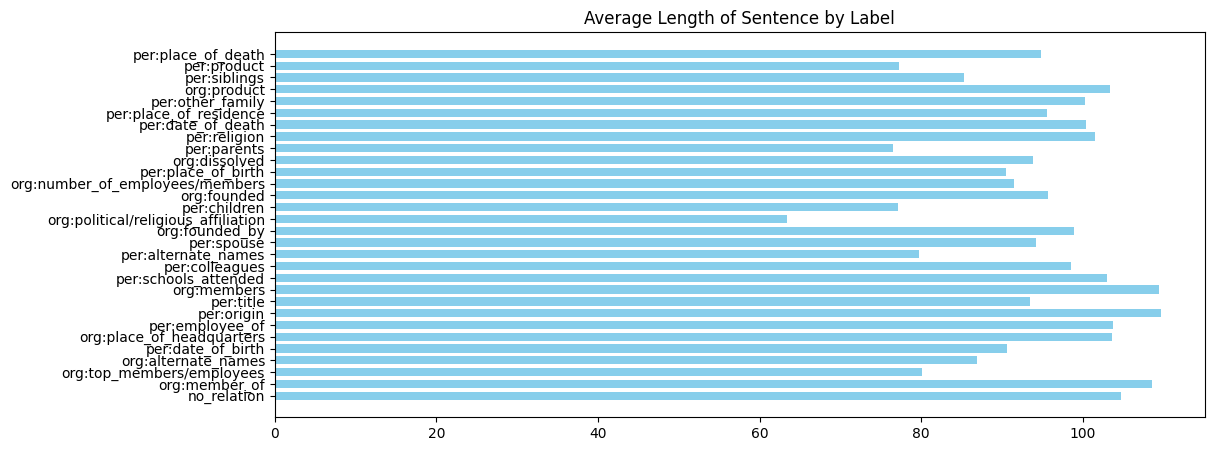

In [19]:
plt.figure(figsize=(12, 5))

plt.barh(train_df['label'].unique(), train_df.groupby('label')['length'].mean(),color='skyblue',height=0.7)
plt.title('Average Length of Sentence by Label')

plt.show()

## 중복 문장 분석 및 오류 데이터 찾기

In [126]:
# 중복 문장 분석

train_df['sentence'].describe()

count                                                 32470
unique                                                28803
top       1380년 샤를 5세가 사망한 후 샤를 6세(재위 1380년 ~ 1422년) 시대에...
freq                                                      3
Name: sentence, dtype: object

In [127]:
train_df[train_df['sentence'] == train_df['sentence'].describe().top]

,id,sentence,subject_entity,object_entity,label,source
6800,6800,1380년 샤를 5세가 사망한 후 샤를 6세(재위 1380년 ~ 1422년) 시대에...,"{'word': '샤를 6세', 'start_idx': 19, 'end_idx': ...","{'word': '1422년', 'start_idx': 36, 'end_idx': ...",no_relation,wikipedia
9807,9807,1380년 샤를 5세가 사망한 후 샤를 6세(재위 1380년 ~ 1422년) 시대에...,"{'word': '샤를 6세', 'start_idx': 19, 'end_idx': ...","{'word': '샤를 5세', 'start_idx': 6, 'end_idx': 1...",no_relation,wikipedia
32307,32307,1380년 샤를 5세가 사망한 후 샤를 6세(재위 1380년 ~ 1422년) 시대에...,"{'word': '샤를 5세', 'start_idx': 6, 'end_idx': 1...","{'word': '샤를 6세', 'start_idx': 19, 'end_idx': ...",no_relation,wikipedia


In [128]:
# 두번 이상 나온 문장들을 추출하고 중복 빈도에 따른 내림차순 정렬

duplicate_sentence_counts = train_df['sentence'].value_counts()
duplicate_sentences = duplicate_sentence_counts[duplicate_sentence_counts > 1].index

# 해당 문장들을 필터링하고 내림차순으로 정렬한 DataFrame 생성
result_df = train_df[train_df['sentence'].isin(duplicate_sentences)]
result_df['sentence_counts'] = result_df['sentence'].map(duplicate_sentence_counts)  # 등장 빈도 열 추가
result_df = result_df.sort_values(by=['sentence_counts', 'sentence'], ascending=[False, False]).drop(columns='sentence_counts')
result_df

/tmp/ipykernel_110155/1658675785.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['sentence_counts'] = result_df['sentence'].map(duplicate_sentence_counts)  # 등장 빈도 열 추가


,id,sentence,subject_entity,object_entity,label,source
9524,9524,"휘그당은 다시 윌리엄 헨리 해리슨을 대통령 후보로 지명하였고, 버지니아 주의 전 상...","{'word': '존 타일러', 'start_idx': 48, 'end_idx': ...","{'word': '휘그당', 'start_idx': 0, 'end_idx': 2, ...",per:employee_of,wikipedia
23936,23936,"휘그당은 다시 윌리엄 헨리 해리슨을 대통령 후보로 지명하였고, 버지니아 주의 전 상...","{'word': '윌리엄 헨리 해리슨', 'start_idx': 8, 'end_id...","{'word': '존 타일러', 'start_idx': 48, 'end_idx': ...",per:colleagues,wikipedia
30438,30438,"휘그당은 다시 윌리엄 헨리 해리슨을 대통령 후보로 지명하였고, 버지니아 주의 전 상...","{'word': '윌리엄 헨리 해리슨', 'start_idx': 8, 'end_id...","{'word': '휘그당', 'start_idx': 0, 'end_idx': 2, ...",per:employee_of,wikipedia
22741,22741,"홍무제의 손자이며, 영락제와 인효문황후 서씨(仁孝文皇后 徐氏)의 장남이다.","{'word': '영락제', 'start_idx': 11, 'end_idx': 13...","{'word': '홍무제', 'start_idx': 0, 'end_idx': 2, ...",per:parents,wikipedia
24087,24087,"홍무제의 손자이며, 영락제와 인효문황후 서씨(仁孝文皇后 徐氏)의 장남이다.","{'word': '영락제', 'start_idx': 11, 'end_idx': 13...","{'word': '인효문황후', 'start_idx': 16, 'end_idx': ...",per:spouse,wikipedia
...,...,...,...,...,...,...
32434,32434,"""탕약망""이란 예수회 선교사 천문학자 아담 샬의 중국 이름이다.","{'word': '아담 샬', 'start_idx': 21, 'end_idx': 2...","{'word': '예수회', 'start_idx': 8, 'end_idx': 10,...",per:employee_of,wikipedia
3588,3588,"""소이현, 인교진이 하는 광고는 괜찮고"", ""차 광고할 때 여자가 남자한테 하던 소...","{'word': '인교진', 'start_idx': 6, 'end_idx': 8, ...","{'word': '소이현', 'start_idx': 52, 'end_idx': 54...",no_relation,wikitree
28051,28051,"""소이현, 인교진이 하는 광고는 괜찮고"", ""차 광고할 때 여자가 남자한테 하던 소...","{'word': '소이현', 'start_idx': 52, 'end_idx': 54...","{'word': '인교진', 'start_idx': 6, 'end_idx': 8, ...",no_relation,wikitree
919,919,"""2006년 지방선거에 참패하고 민주당과 그 전신인 열린 우리당은 노 씨의 국정 운...","{'word': '열린 우리당', 'start_idx': 29, 'end_idx':...","{'word': '노무현', 'start_idx': 127, 'end_idx': 1...",no_relation,wikipedia


In [129]:
# sentence, subject, object entity가 같지만, label이 다른 이상한 데이터를 찾기 위해 
# 먼저, sentence, subject, object entity가 같은 데이터 찾기
sentnece_sb_ob_equal = result_df[result_df.duplicated(subset=['sentence','subject_entity', 'object_entity'], keep=False)]
sentnece_sb_ob_equal

,id,sentence,subject_entity,object_entity,label,source
277,277,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",no_relation,wikitree
3296,3296,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",per:title,wikitree
10202,10202,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",no_relation,wikitree
17142,17142,"이 책은 천정배 의원의 유년기와 전남 신안 암태 동초등학교, 목포중·고등학교 시절 ...","{'word': '새정치국민회의', 'start_idx': 110, 'end_idx...","{'word': '김대중', 'start_idx': 103, 'end_idx': 1...",org:top_members/employees,wikitree
31038,31038,"이 책은 천정배 의원의 유년기와 전남 신안 암태 동초등학교, 목포중·고등학교 시절 ...","{'word': '새정치국민회의', 'start_idx': 110, 'end_idx...","{'word': '김대중', 'start_idx': 103, 'end_idx': 1...",org:top_members/employees,wikitree
...,...,...,...,...,...,...
3547,3547,2010년 10월 15일 전라북도청을 방문한 맹형규 행정안전부 장관은 도내 지자체간...,"{'word': '전라북도청', 'start_idx': 14, 'end_idx': ...","{'word': '행정안전부', 'start_idx': 29, 'end_idx': ...",no_relation,wikipedia
2500,2500,2001년 4월 민주국민당 김윤환 의원과 민주당 의원 사이의 정책 연합과 관련한 통...,"{'word': '민주국민당', 'start_idx': 9, 'end_idx': 1...","{'word': '민주당', 'start_idx': 23, 'end_idx': 25...",no_relation,wikipedia
25368,25368,2001년 4월 민주국민당 김윤환 의원과 민주당 의원 사이의 정책 연합과 관련한 통...,"{'word': '민주국민당', 'start_idx': 9, 'end_idx': 1...","{'word': '민주당', 'start_idx': 23, 'end_idx': 25...",no_relation,wikipedia
9618,9618,"1959-60 시즌 이후의 알파 에트니키 / 수페르리가 엘라다, 그리스 컵, 그리고...","{'word': '수페르리가 엘라다', 'start_idx': 25, 'end_id...","{'word': '그리스', 'start_idx': 36, 'end_idx': 38...",no_relation,wikipedia


In [130]:
grouped = sentnece_sb_ob_equal.groupby(['sentence', 'subject_entity', 'object_entity'])['label'].nunique()

# 두 개 이상의 서로 다른 label이 있는 그룹만 추출
result_groups = grouped[grouped > 1].index

# 해당 그룹들을 필터링한 DataFrame 생성
result_df = sentnece_sb_ob_equal[sentnece_sb_ob_equal.set_index(['sentence', 'subject_entity', 'object_entity']).index.isin(result_groups)]
result_df

,id,sentence,subject_entity,object_entity,label,source
277,277,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",no_relation,wikitree
3296,3296,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",per:title,wikitree
10202,10202,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",no_relation,wikitree
6749,6749,대한항공은 5일 조양호 회장의 3자녀가 보유한 싸이버스카이 주식 9만9900주 전량...,"{'word': '대한항공', 'start_idx': 0, 'end_idx': 3,...","{'word': '조양호', 'start_idx': 9, 'end_idx': 11,...",no_relation,wikipedia
12829,12829,대한항공은 5일 조양호 회장의 3자녀가 보유한 싸이버스카이 주식 9만9900주 전량...,"{'word': '대한항공', 'start_idx': 0, 'end_idx': 3,...","{'word': '조양호', 'start_idx': 9, 'end_idx': 11,...",org:top_members/employees,wikipedia
4212,4212,한편 전라남도는 최근 확진자가 발생한 순천시와 여수시에 마스크를 각각 2만장씩 총 ...,"{'word': '전라남도', 'start_idx': 3, 'end_idx': 6,...","{'word': '여수시', 'start_idx': 26, 'end_idx': 28...",org:members,wikitree
25094,25094,한편 전라남도는 최근 확진자가 발생한 순천시와 여수시에 마스크를 각각 2만장씩 총 ...,"{'word': '전라남도', 'start_idx': 3, 'end_idx': 6,...","{'word': '여수시', 'start_idx': 26, 'end_idx': 28...",org:place_of_headquarters,wikitree
11511,11511,"영화 '버즈 오브 프레이'는 배트맨이 없는 고담시에서 할리퀸, 헌트리스, 블랙 카나...","{'word': '배트맨', 'start_idx': 16, 'end_idx': 18...","{'word': '고담시', 'start_idx': 24, 'end_idx': 26...",per:place_of_residence,wikitree
22258,22258,"영화 '버즈 오브 프레이'는 배트맨이 없는 고담시에서 할리퀸, 헌트리스, 블랙 카나...","{'word': '배트맨', 'start_idx': 16, 'end_idx': 18...","{'word': '고담시', 'start_idx': 24, 'end_idx': 26...",no_relation,wikitree
8364,8364,배우 김병철 씨가 연기하는 정복동은 천리마마트를 망하게 하기 위해 여러 계획을 세우...,"{'word': '정복동', 'start_idx': 15, 'end_idx': 17...","{'word': '김병철', 'start_idx': 3, 'end_idx': 5, ...",no_relation,wikitree


## 한자 등장 빈도 분석

In [101]:
def find_chinese_characters(sentence):
    chinese_characters = [char for char in sentence if '\u4e00' <= char <= '\u9fff']
    return chinese_characters

train_df = train_df.copy()
train_df['chineese_character'] = train_df['sentence'].apply(find_chinese_characters)

train_df['has_chinese'] = train_df['sentence'].str.contains('[\u4e00-\u9fff]')

chinese_samples = train_df[train_df['has_chinese']]
chinese_samples

,id,sentence,subject_entity,object_entity,label,source,chineese_character,has_chinese
7,7,"박용오(朴容旿, 1937년 4월 29일(음력 3월 19일)(음력 3월 19일) ~ ...","{'word': '박용오', 'start_idx': 0, 'end_idx': 2, ...","{'word': '1937년 4월 29일', 'start_idx': 9, 'end_...",per:date_of_birth,wikipedia,"[朴, 容, 旿]",True
62,62,"김동성(金東聖, 1980년 2월 9일 ~)은 대한민국의 쇼트트랙 선수이다.","{'word': '김동성', 'start_idx': 0, 'end_idx': 2, ...","{'word': '1980년 2월 9일', 'start_idx': 9, 'end_i...",per:date_of_birth,wikipedia,"[金, 東, 聖]",True
69,69,칸트는 미(美)란 숭고함이다라고 주장하였는데 그의 이러한 주장은 윌리엄 터너(Jos...,"{'word': '윌리엄 터너', 'start_idx': 36, 'end_idx':...","{'word': '낭만주의', 'start_idx': 78, 'end_idx': 8...",no_relation,wikipedia,[美],True
83,83,진도군은 진도개를 보기 위해 찾아온 관람객들에게 더욱 흥미롭고 즐거움을 선사하기 위...,"{'word': '진도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '진도개', 'start_idx': 5, 'end_idx': 7, ...",no_relation,wikitree,[犬],True
91,91,"백한성(白漢成, 水原鶴人, 1899년 6월 15일 조선 충청도 공주 출생 ~ 197...","{'word': '백한성', 'start_idx': 0, 'end_idx': 2, ...","{'word': '조선 충청도 공주', 'start_idx': 28, 'end_id...",per:place_of_birth,wikipedia,"[白, 漢, 成, 水, 原, 鶴, 人]",True
...,...,...,...,...,...,...,...,...
32402,32402,"1990년 국가보훈처에 의해 이상룡(李相龍), 이승화(李承和), 이광민(李光民) 등...","{'word': '이광민', 'start_idx': 36, 'end_idx': 38...","{'word': '독립운동가', 'start_idx': 49, 'end_idx': ...",per:title,wikipedia,"[李, 相, 龍, 李, 承, 和, 李, 光, 民]",True
32411,32411,"가톨릭평화방송(가톨릭平和放送, Catholic Peace Broadcasting C...","{'word': '가톨릭평화방송', 'start_idx': 0, 'end_idx':...","{'word': '가톨릭平和放送', 'start_idx': 8, 'end_idx':...",org:alternate_names,wikipedia,"[平, 和, 放, 送]",True
32438,32438,"간 나오토는 총리 취임에 즈음해 당 간사장에 에다노 유키오, 내각관방장관에 센고쿠 ...","{'word': '에다노 유키오', 'start_idx': 25, 'end_idx'...","{'word': '센고쿠 요시토', 'start_idx': 42, 'end_idx'...",no_relation,wikipedia,[非],True
32449,32449,"이때 만주 지역에는 크고작은 독립군이 조직되었고, 동만주지방의 홍범도가 이끄는 대한...","{'word': '홍범도', 'start_idx': 35, 'end_idx': 37...","{'word': '대한독립군', 'start_idx': 44, 'end_idx': ...",per:employee_of,wikipedia,"[安, 武, 崔, 振, 東]",True


# Train_Dev 데이터셋 분할

### 이상치 데이터 제거

In [133]:
wrong_label_df = result_df
wrong_label_df

,id,sentence,subject_entity,object_entity,label,source
277,277,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",no_relation,wikitree
3296,3296,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",per:title,wikitree
10202,10202,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",no_relation,wikitree
6749,6749,대한항공은 5일 조양호 회장의 3자녀가 보유한 싸이버스카이 주식 9만9900주 전량...,"{'word': '대한항공', 'start_idx': 0, 'end_idx': 3,...","{'word': '조양호', 'start_idx': 9, 'end_idx': 11,...",no_relation,wikipedia
12829,12829,대한항공은 5일 조양호 회장의 3자녀가 보유한 싸이버스카이 주식 9만9900주 전량...,"{'word': '대한항공', 'start_idx': 0, 'end_idx': 3,...","{'word': '조양호', 'start_idx': 9, 'end_idx': 11,...",org:top_members/employees,wikipedia
4212,4212,한편 전라남도는 최근 확진자가 발생한 순천시와 여수시에 마스크를 각각 2만장씩 총 ...,"{'word': '전라남도', 'start_idx': 3, 'end_idx': 6,...","{'word': '여수시', 'start_idx': 26, 'end_idx': 28...",org:members,wikitree
25094,25094,한편 전라남도는 최근 확진자가 발생한 순천시와 여수시에 마스크를 각각 2만장씩 총 ...,"{'word': '전라남도', 'start_idx': 3, 'end_idx': 6,...","{'word': '여수시', 'start_idx': 26, 'end_idx': 28...",org:place_of_headquarters,wikitree
11511,11511,"영화 '버즈 오브 프레이'는 배트맨이 없는 고담시에서 할리퀸, 헌트리스, 블랙 카나...","{'word': '배트맨', 'start_idx': 16, 'end_idx': 18...","{'word': '고담시', 'start_idx': 24, 'end_idx': 26...",per:place_of_residence,wikitree
22258,22258,"영화 '버즈 오브 프레이'는 배트맨이 없는 고담시에서 할리퀸, 헌트리스, 블랙 카나...","{'word': '배트맨', 'start_idx': 16, 'end_idx': 18...","{'word': '고담시', 'start_idx': 24, 'end_idx': 26...",no_relation,wikitree
8364,8364,배우 김병철 씨가 연기하는 정복동은 천리마마트를 망하게 하기 위해 여러 계획을 세우...,"{'word': '정복동', 'start_idx': 15, 'end_idx': 17...","{'word': '김병철', 'start_idx': 3, 'end_idx': 5, ...",no_relation,wikitree


In [134]:
# 이상치 데이터 제거 이전
train_df

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia
...,...,...,...,...,...,...
32465,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree
32466,32466,"법포는 다시 최시형, 서병학, 손병희 직계인 북접과 다시 서장옥, 전봉준, 김개남을...","{'word': '최시형', 'start_idx': 7, 'end_idx': 9, ...","{'word': '손병희', 'start_idx': 17, 'end_idx': 19...",per:colleagues,wikipedia
32467,32467,완도군(군수 신우철)이 국토교통부에서 실시한 '2019 교통문화지수 실태조사'에서 ...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree
32468,32468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 이...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia


In [135]:
# 이상치 데이터 제거 ( 개수 : 11개 ) ( 32470 -> 32459 )
clean_train_df = train_df.drop(wrong_label_df.index)
clean_train_df

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia
...,...,...,...,...,...,...
32465,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree
32466,32466,"법포는 다시 최시형, 서병학, 손병희 직계인 북접과 다시 서장옥, 전봉준, 김개남을...","{'word': '최시형', 'start_idx': 7, 'end_idx': 9, ...","{'word': '손병희', 'start_idx': 17, 'end_idx': 19...",per:colleagues,wikipedia
32467,32467,완도군(군수 신우철)이 국토교통부에서 실시한 '2019 교통문화지수 실태조사'에서 ...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree
32468,32468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 이...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia


### 중복데이터 포함시켜 train에 몰아넣기

In [141]:
# 중복데이터 샘플링

duplicate_sentence_counts = clean_train_df['sentence'].value_counts()
duplicate_sentences = duplicate_sentence_counts[duplicate_sentence_counts > 1].index

# 중복 문장 필터링
dup_df = clean_train_df[clean_train_df['sentence'].isin(duplicate_sentences)]
dup_df

,id,sentence,subject_entity,object_entity,label,source
6,6,그에 따라 나폴리와 계약을 연장한 마라도나는 1989년 팀을 UEFA컵 정상으로 인...,"{'word': 'AC 밀란', 'start_idx': 64, 'end_idx': ...","{'word': '1989', 'start_idx': 25, 'end_idx': 2...",no_relation,wikipedia
7,7,"박용오(朴容旿, 1937년 4월 29일(음력 3월 19일)(음력 3월 19일) ~ ...","{'word': '박용오', 'start_idx': 0, 'end_idx': 2, ...","{'word': '1937년 4월 29일', 'start_idx': 9, 'end_...",per:date_of_birth,wikipedia
9,9,"특히 김동연 전 경제부총리를 비롯한 김두관 국회의원, 안규백 국회의원, 김종민 국회...","{'word': '안규백', 'start_idx': 30, 'end_idx': 32...","{'word': '더불어민주당', 'start_idx': 100, 'end_idx'...",per:employee_of,wikitree
10,10,하비에르 파스토레는 아르헨티나 클럽 타예레스의 유소년팀에서 축구를 시작하였다.,"{'word': '하비에르 파스토레', 'start_idx': 0, 'end_idx...","{'word': '아르헨티나', 'start_idx': 11, 'end_idx': ...",per:origin,wikipedia
12,12,"2009년 9월, 미국 프로 야구 필라델피아 필리스 소속의 야구 선수 박찬호는 《M...","{'word': '필라델피아 필리스', 'start_idx': 19, 'end_id...","{'word': '박찬호', 'start_idx': 39, 'end_idx': 41...",org:top_members/employees,wikipedia
...,...,...,...,...,...,...
32451,32451,"반면 정재학의 3남인 정종원은 제5대 조흥은행장, 손자인 정운용은 제2대 조흥은행장...","{'word': '정종원', 'start_idx': 12, 'end_idx': 14...","{'word': '정재학', 'start_idx': 3, 'end_idx': 5, ...",per:parents,wikipedia
32454,32454,신라에서는 중기까지도 지배계층의 가계계승에 있어서 모계적인 경향이 그대로 존속되었고...,"{'word': '선덕여왕', 'start_idx': 101, 'end_idx': ...","{'word': '진덕여왕', 'start_idx': 95, 'end_idx': 9...",no_relation,wikipedia
32463,32463,"그의 외삼촌은 루이 13세로, 남편인 루이 14세는 외사촌 오빠가 된다.","{'word': '루이 14세', 'start_idx': 21, 'end_idx':...","{'word': '루이 13세', 'start_idx': 8, 'end_idx': ...",per:other_family,wikipedia
32465,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree


전체 데이터 개수 : 32459\
중복 데이터 개수 : 7078\
중복 제거 데이터 개수 : 25381

In [142]:
# 중복데이터를 제거한 데이터
without_dup_train_df = clean_train_df.drop(dup_df.index)
without_dup_train_df

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia
...,...,...,...,...,...,...
32462,32462,심지어 전용 연습구장도 없어 훈련을 여러 지역을 돌아다니며 해야 할 정도로 팀 사정...,"{'word': '방승환', 'start_idx': 85, 'end_idx': 87...","{'word': '공격수', 'start_idx': 94, 'end_idx': 96...",no_relation,wikipedia
32464,32464,KIA타이거즈 외야수 이창진이 롯데백화점 광주점이 시상하는 9월 월간 MVP에 선정...,"{'word': '이창진', 'start_idx': 12, 'end_idx': 14...","{'word': '외야수', 'start_idx': 8, 'end_idx': 10,...",per:title,wikitree
32467,32467,완도군(군수 신우철)이 국토교통부에서 실시한 '2019 교통문화지수 실태조사'에서 ...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree
32468,32468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 이...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia


train : dev = 9 : 1 =>\
Train : 29,213(22,135 + 7078[중복])\
Dev : 3,246

In [143]:
from sklearn.model_selection import train_test_split

train_df, dev_df = train_test_split(train_df, train_size=22135, test_size=3246, random_state=42)

In [144]:
len(train_df), len(dev_df)

(22135, 3246)

In [146]:
# 중복 데이터 추가

train_df = pd.concat([train_df, dup_df])
train_df

,id,sentence,subject_entity,object_entity,label,source
963,963,"2011년 10월, 펜탁스는 일본의 사무기기, 카메라 제조 업체인 리코에 인수 되었...","{'word': '펜탁스', 'start_idx': 11, 'end_idx': 13...","{'word': '카메라', 'start_idx': 26, 'end_idx': 28...",org:product,wikipedia
12858,12858,여수시(시장 권오봉)가 창의적인 아이디어와 열정적인 창업의지를 가진 ‘여수형 청년 ...,"{'word': '여수시', 'start_idx': 0, 'end_idx': 2, ...","{'word': '권오봉', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree
9362,9362,정승일 산업통상자원부 차관은 “디지털 기술이 산업 현장에서 원활하게 작동되도록 산업...,"{'word': '산업통상자원부', 'start_idx': 4, 'end_idx':...","{'word': '정승일', 'start_idx': 0, 'end_idx': 2, ...",org:top_members/employees,policy_briefing
2323,2323,"감독에서 은퇴한 후에는 정치에 입문하여 제슈프 시의원(2001~2005), 폴란드 ...","{'word': '제슈프', 'start_idx': 22, 'end_idx': 24...","{'word': '폴란드', 'start_idx': 42, 'end_idx': 44...",no_relation,wikipedia
15626,15626,2011년 9월 19일 여의도순복음교회 장로 29명은 조용기 원로목사와 조 목사의 ...,"{'word': '여의도순복음교회', 'start_idx': 13, 'end_idx...","{'word': '조용기', 'start_idx': 30, 'end_idx': 32...",org:top_members/employees,wikipedia
...,...,...,...,...,...,...
32451,32451,"반면 정재학의 3남인 정종원은 제5대 조흥은행장, 손자인 정운용은 제2대 조흥은행장...","{'word': '정종원', 'start_idx': 12, 'end_idx': 14...","{'word': '정재학', 'start_idx': 3, 'end_idx': 5, ...",per:parents,wikipedia
32454,32454,신라에서는 중기까지도 지배계층의 가계계승에 있어서 모계적인 경향이 그대로 존속되었고...,"{'word': '선덕여왕', 'start_idx': 101, 'end_idx': ...","{'word': '진덕여왕', 'start_idx': 95, 'end_idx': 9...",no_relation,wikipedia
32463,32463,"그의 외삼촌은 루이 13세로, 남편인 루이 14세는 외사촌 오빠가 된다.","{'word': '루이 14세', 'start_idx': 21, 'end_idx':...","{'word': '루이 13세', 'start_idx': 8, 'end_idx': ...",per:other_family,wikipedia
32465,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree


In [147]:
# 데이터 저장

train_df.to_csv('../dataset/with_dup_train.csv', index=False)
dev_df.to_csv('../dataset/with_dup_dev.csv', index=False)

### 중복되는 문장을 1개로 통일 후 분리

In [152]:
# 이상치를 제외한 sentence가 중복되는 문장만 추출
dup_df

,id,sentence,subject_entity,object_entity,label,source
6,6,그에 따라 나폴리와 계약을 연장한 마라도나는 1989년 팀을 UEFA컵 정상으로 인...,"{'word': 'AC 밀란', 'start_idx': 64, 'end_idx': ...","{'word': '1989', 'start_idx': 25, 'end_idx': 2...",no_relation,wikipedia
7,7,"박용오(朴容旿, 1937년 4월 29일(음력 3월 19일)(음력 3월 19일) ~ ...","{'word': '박용오', 'start_idx': 0, 'end_idx': 2, ...","{'word': '1937년 4월 29일', 'start_idx': 9, 'end_...",per:date_of_birth,wikipedia
9,9,"특히 김동연 전 경제부총리를 비롯한 김두관 국회의원, 안규백 국회의원, 김종민 국회...","{'word': '안규백', 'start_idx': 30, 'end_idx': 32...","{'word': '더불어민주당', 'start_idx': 100, 'end_idx'...",per:employee_of,wikitree
10,10,하비에르 파스토레는 아르헨티나 클럽 타예레스의 유소년팀에서 축구를 시작하였다.,"{'word': '하비에르 파스토레', 'start_idx': 0, 'end_idx...","{'word': '아르헨티나', 'start_idx': 11, 'end_idx': ...",per:origin,wikipedia
12,12,"2009년 9월, 미국 프로 야구 필라델피아 필리스 소속의 야구 선수 박찬호는 《M...","{'word': '필라델피아 필리스', 'start_idx': 19, 'end_id...","{'word': '박찬호', 'start_idx': 39, 'end_idx': 41...",org:top_members/employees,wikipedia
...,...,...,...,...,...,...
32451,32451,"반면 정재학의 3남인 정종원은 제5대 조흥은행장, 손자인 정운용은 제2대 조흥은행장...","{'word': '정종원', 'start_idx': 12, 'end_idx': 14...","{'word': '정재학', 'start_idx': 3, 'end_idx': 5, ...",per:parents,wikipedia
32454,32454,신라에서는 중기까지도 지배계층의 가계계승에 있어서 모계적인 경향이 그대로 존속되었고...,"{'word': '선덕여왕', 'start_idx': 101, 'end_idx': ...","{'word': '진덕여왕', 'start_idx': 95, 'end_idx': 9...",no_relation,wikipedia
32463,32463,"그의 외삼촌은 루이 13세로, 남편인 루이 14세는 외사촌 오빠가 된다.","{'word': '루이 14세', 'start_idx': 21, 'end_idx':...","{'word': '루이 13세', 'start_idx': 8, 'end_idx': ...",per:other_family,wikipedia
32465,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree


In [172]:
# sentence, subject_entity, object_entity, label까지 모두 동일한 데이터의 unique한 sentence 개수
unique_dup=dup_df[dup_df.duplicated(subset=['sentence', 'subject_entity', 'object_entity', 'label'], keep=False)]['sentence'].value_counts()
# unique_dup = clean_train_df[clean_train_df.duplicated(subset=['sentence','subject_entity', 'object_entity'], keep='first')] : data 샘플로 볼 수 있음
unique_dup

sentence
2010년 10월 15일 전라북도청을 방문한 맹형규 행정안전부 장관은 도내 지자체간 미묘한 갈등을 보이고 있는 새만금 행정구역 개편에 대해 "매우 골치 아픈 일이지만 새만금 내부개발에 있어 중요한 일인 만큼 분쟁이 비교적 적은 3~4호 방조제 구간에 대해서는 제5차 중앙분쟁조정위원회에서 결론을 낼 것으로 본다"며 "나머지 구간에 대해서도 지자체간의 협의점을 도출해 내 조속히 마무리될 수 있도록 노력하겠다"고 말했다.                                                                                                    2
배우 마동석, 박정민, 정해인, 염정아, 최성은, 윤경호 씨가 출연하는 영화 '시동'은 오는 18일 개봉한다.                                                                                                                                                                                                                                                                                 2
특히, KRI 한국기록원으로부터 2년 연속 공인중개사 최다 합격자 배출 기록을 공식 인증받았으며 한국리서치로부터 공무원 선호도, 인지도 1위 기업을 입증받은 기업이다.                                                                                                                                                                                                                                  

In [173]:
unique_dup.values, len(unique_dup)

(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 41)

중복 중 unique한 것들만 남기면\
7078-41=7037

In [175]:
# unique한 샘플만 들어있는 train_df

unique_dup_df = clean_train_df[clean_train_df.duplicated(subset=['sentence','subject_entity', 'object_entity'], keep='first')] # 중복되는 것 중 첫번째 것만 남기고 제거

# 이것만 clean_train_df에서 제거하면 됨 ( 32459 -> 32418)

unique_train_df = clean_train_df.drop(unique_dup_df.index)
unique_train_df

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia
...,...,...,...,...,...,...
32465,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree
32466,32466,"법포는 다시 최시형, 서병학, 손병희 직계인 북접과 다시 서장옥, 전봉준, 김개남을...","{'word': '최시형', 'start_idx': 7, 'end_idx': 9, ...","{'word': '손병희', 'start_idx': 17, 'end_idx': 19...",per:colleagues,wikipedia
32467,32467,완도군(군수 신우철)이 국토교통부에서 실시한 '2019 교통문화지수 실태조사'에서 ...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree
32468,32468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 이...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia


In [176]:
# 9대 1로 분할

from sklearn.model_selection import train_test_split

without_dup_train, without_dup_dev = train_test_split(unique_train_df, test_size=0.1, random_state=42)

len(without_dup_train), len(without_dup_dev)

(29176, 3242)

Train, Dev : (29176, 3242)

In [177]:
# 데이터 저장

without_dup_train.to_csv('../dataset/without_dup_train.csv', index=False)
without_dup_dev.to_csv('../dataset/without_dup_dev.csv', index=False)

### 중복되는 문장을 1개로 통일 후, train 라벨과 균등하게 분리

In [4]:
# 중복이 없는 데이터 불러오기

without_dup_train_df = pd.read_csv('../dataset/without_dup_train.csv')
without_dup_dev_df = pd.read_csv('../dataset/without_dup_dev.csv')

# 하나로 합치기

without_dup_total_df = pd.concat([without_dup_train_df, without_dup_dev_df])
without_dup_total_df

,id,sentence,subject_entity,object_entity,label,source
0,26569,"《리베리오 교황표》에 의하면, 5월 22일 교황 율리오 1세의 뒤를 이어 로마 주교...","{'word': '율리오 1세', 'start_idx': 27, 'end_idx':...","{'word': '리베리오', 'start_idx': 1, 'end_idx': 4,...",no_relation,wikipedia
1,15955,그러나 메르센부르크의 주교 테이도마르(Thietmar)와 마인츠 대주교 아리보(Ar...,"{'word': '콘라트 2세', 'start_idx': 52, 'end_idx':...","{'word': '기젤라', 'start_idx': 60, 'end_idx': 62...",per:spouse,wikipedia
2,13409,새정치국민회의는 안정적인 국정 운영을 위해 공동 여당에서 국회의장을 차지해야 한다고...,"{'word': '자유민주연합', 'start_idx': 55, 'end_idx':...","{'word': '한나라당', 'start_idx': 77, 'end_idx': 8...",no_relation,wikipedia
3,7606,"한편, 고창군은 전라북도 군 단위에서는 최초로 지난 16일 여성가족부로부터 2019...","{'word': '고창군', 'start_idx': 4, 'end_idx': 6, ...","{'word': '전라북도', 'start_idx': 9, 'end_idx': 12...",org:member_of,wikitree
4,24814,선진 강연 문화를 선도하고 있는 장성아카데미는 지난해 9월 KRI 한국기록원으로부터...,"{'word': '한국기록원', 'start_idx': 37, 'end_idx': ...","{'word': 'KRI', 'start_idx': 33, 'end_idx': 35...",org:alternate_names,wikitree
...,...,...,...,...,...,...
3237,26593,"1회말 이순철의 도루를 곁들여 만든 2사1, 2루에서 김성한의 우전적시타로 1점을 ...","{'word': '홍현우', 'start_idx': 87, 'end_idx': 89...","{'word': '2루수', 'start_idx': 92, 'end_idx': 94...",no_relation,wikipedia
3238,1046,"2009년 9월 16일, 아소 내각이 총사직하고 국회에서 민주당 대표인 하토야마 유...","{'word': '하토야마 유키오', 'start_idx': 40, 'end_idx...","{'word': '2009년 9월 16일', 'start_idx': 0, 'end_...",no_relation,wikipedia
3239,465,고구려 장수왕(재위: 412년 음력 10월~491년 음력 12월)의 군사들이 한성으...,"{'word': '개로왕', 'start_idx': 52, 'end_idx': 54...","{'word': '문주왕', 'start_idx': 74, 'end_idx': 76...",per:children,wikipedia
3240,22194,태조 왕건을 도운 공신이자 927년 후백제와의 공산성 전투중 전사한 신숭겸과 김낙 ...,"{'word': '신숭겸', 'start_idx': 38, 'end_idx': 40...","{'word': '927년', 'start_idx': 15, 'end_idx': 1...",per:date_of_death,wikipedia


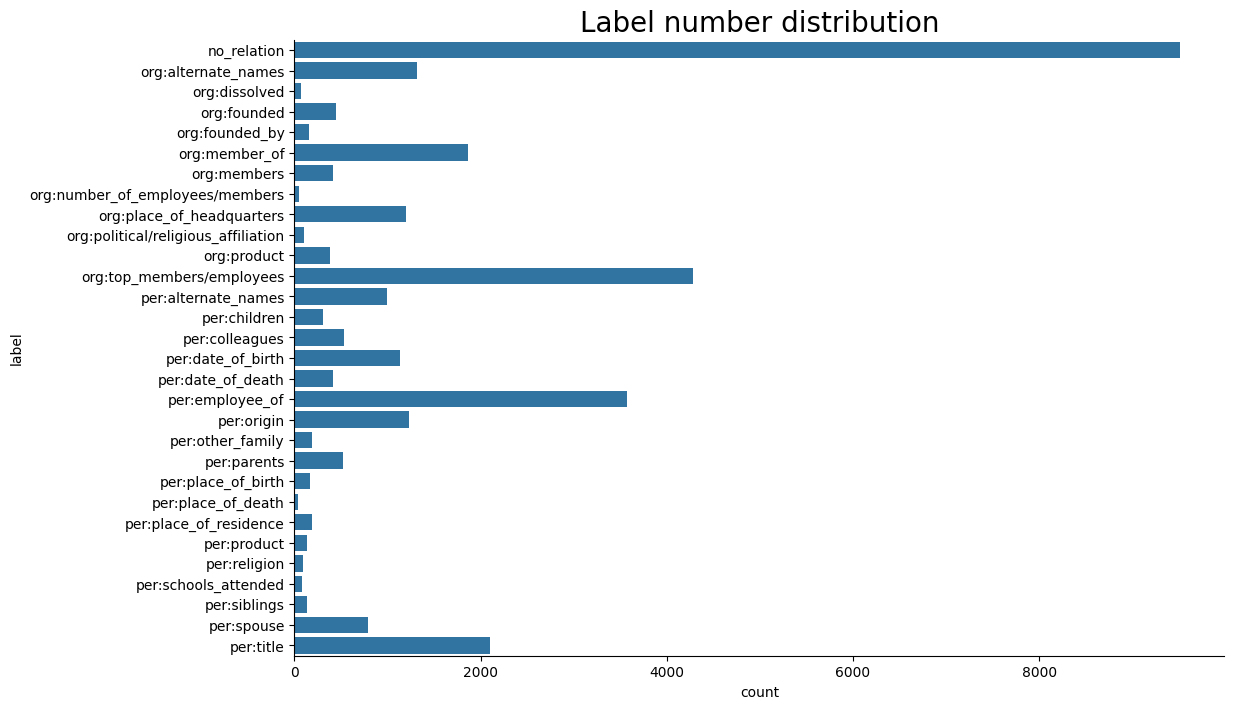

In [17]:
# 라벨 개수 분포 시각화

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
ax = sns.countplot(data=without_dup_total_df.sort_values('label'), y='label')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Label number distribution', fontsize=20)

plt.show()

In [14]:
# 라벨 분포를 유지하면서 9대 1로 분리

from sklearn.model_selection import train_test_split

train_df, dev_df = train_test_split(without_dup_total_df, test_size=0.1, random_state=42, stratify=without_dup_total_df['label'])

len(train_df), len(dev_df)

(29176, 3242)

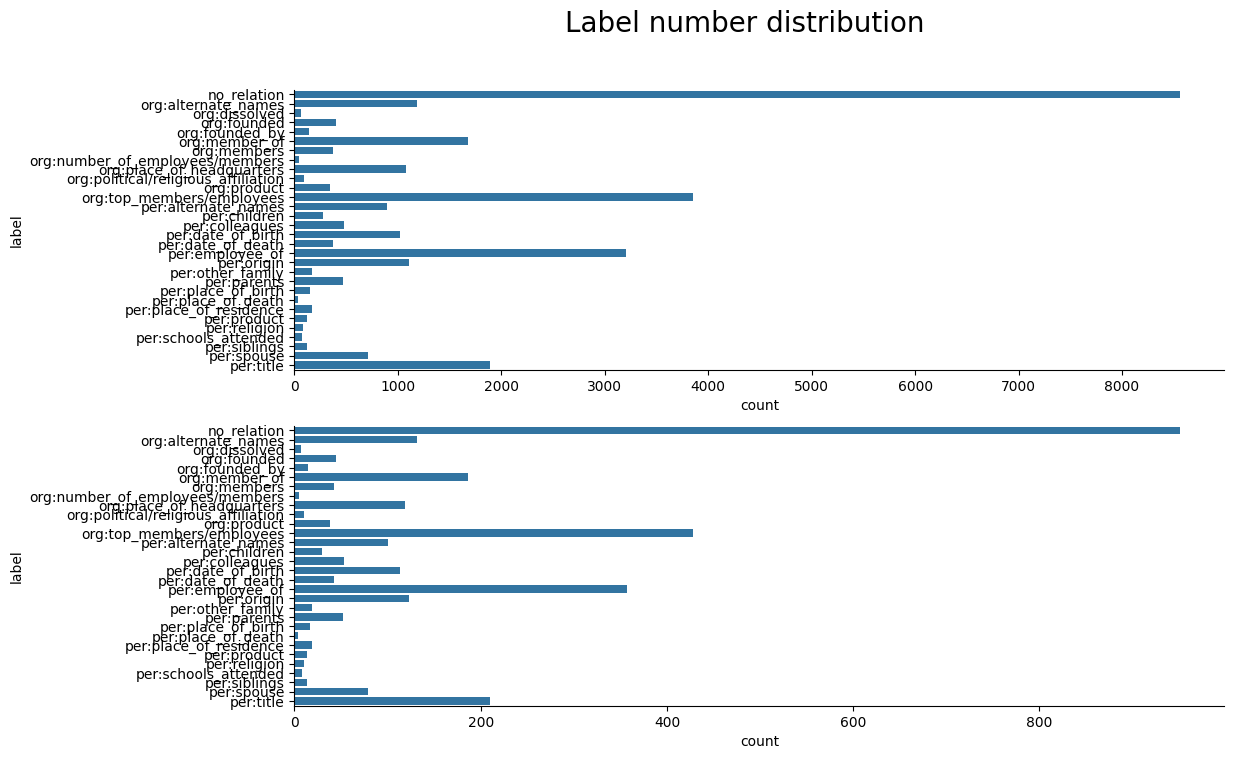

In [28]:
plt.figure(figsize=(12, 8))

# 첫 번째 subplot
plt.subplot(2, 1, 1)
ax = sns.countplot(data=train_df.sort_values('label'), y='label')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 두 번째 subplot
plt.subplot(2, 1, 2)
ax2 = sns.countplot(data=dev_df.sort_values('label'), y='label')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.suptitle('Label number distribution', fontsize=20)

plt.show()

In [29]:
# 데이터 저장

train_df.to_csv('../dataset/stratified_without_dup_train.csv', index=False)
dev_df.to_csv('../dataset/stratified_without_dup_dev.csv', index=False)